In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from typing import Counter
import imblearn
from imblearn.over_sampling import SMOTE

from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate
from functions_folder.nn_equalized_odds import equalised_odds
from functions_folder.long import *
from functions_folder.specific_antibiotics import specific_antibiotics
from functions_folder.asi import calculate_asi
import scipy.stats as stats
from numpy import mean
from numpy import std

In [3]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Data

In [5]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
#all_shap_importance = pd.read_csv('VSCode_projects/stop/csv/all_shap_importance.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [6]:
data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)

In [8]:
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

The model has 167,371 trainable parameters


### Run

In [9]:
# Run long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = run_fun(data_dict, model, 'long')

100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


Test AUROC result: 0.8181931153520087
Test AUROC result 2: 0.8135318890698284


100%|██████████| 1/1 [00:00<00:00, 46.84it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


UPDATED BEST OVERALL MODEL


100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


Test AUROC result: 0.8151415811478526
Test AUROC result 2: 0.8127945648042569


100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


Test AUROC result: 0.8106105962755853
Test AUROC result 2: 0.8127293682850196


100%|██████████| 9/9 [00:01<00:00,  4.84it/s]


Test AUROC result: 0.7934074254346827
Test AUROC result 2: 0.7917106081501313


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


Test AUROC result: 0.8002207170879898
Test AUROC result 2: 0.7981105647083077


100%|██████████| 1/1 [00:00<00:00, 51.80it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


Test AUROC result: 0.7862590749653315
Test AUROC result 2: 0.786702626641651


100%|██████████| 1/1 [00:00<00:00, 299.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


Test AUROC result: 0.7961199661076561
Test AUROC result 2: 0.7910640917011718


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


Test AUROC result: 0.8187727456964892
Test AUROC result 2: 0.8177307940745537


100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


UPDATED BEST OVERALL MODEL


100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


Test AUROC result: 0.8167165171153207
Test AUROC result 2: 0.815103708482396


100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


Test AUROC result: 0.7806965407786487
Test AUROC result 2: 0.7816285547710048


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


In [10]:
# Save 
#with open("long_test_results", "wb") as fp:   #Pickling
#    pickle.dump(test_results, fp)
#with open("long_ub_test_results", "wb") as fp:   #Pickling
#    pickle.dump(ub_test_results, fp)

In [11]:
analyze_results_fun(test_results)

mean test_auroc: 0.8021106770688322
std test_auroc: 0.012935485290205231
test_auroc 2.5th percentile: 0.7827702209419002
test_auroc 97.5th percentile: 0.8171396998163183
mean test_accuracy: 0.770054451900287
std test_accuracy: 0.029953655364015064
test_accuracy 2.5th percentile: 0.7250775946997737
test_accuracy 97.5th percentile: 0.8137207681768791
mean test_balanced_accuracy: 0.802110677068832
std test_balanced_accuracy: 0.012935485290205238
test_balanced_accuracy 2.5th percentile: 0.7827702209419001
test_balanced_accuracy 97.5th percentile: 0.8171396998163182
mean test_recall: 0.8501191715787503
std test_recall: 0.038429864988386235
test_recall 2.5th percentile: 0.7955071558382553
test_recall 97.5th percentile: 0.9119906415935695
mean test_precision: 0.4125744592920504
std test_precision: 0.03895062078627583
test_precision 2.5th percentile: 0.3493806049762743
test_precision 97.5th percentile: 0.4750035360345494
mean test_f1: 0.5536254108618199
std test_f1: 0.03160555506188334
test_f1

In [12]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7513943169477978
std test_auroc: 0.0222353611564699
test_auroc 2.5th percentile: 0.7062429231280237
test_auroc 97.5th percentile: 0.7755822172650229
mean test_accuracy: 0.848782338256704
std test_accuracy: 0.0152921264558062
test_accuracy 2.5th percentile: 0.8204814353867121
test_accuracy 97.5th percentile: 0.8671778115980175
mean test_balanced_accuracy: 0.7513943169477978
std test_balanced_accuracy: 0.022235361156469947
test_balanced_accuracy 2.5th percentile: 0.7062429231280236
test_balanced_accuracy 97.5th percentile: 0.7755822172650229
mean test_recall: 0.6051128289355313
std test_recall: 0.06271791550268307
test_recall 2.5th percentile: 0.5063203300825206
test_recall 97.5th percentile: 0.6952489837398373
mean test_precision: 0.5486104673958159
std test_precision: 0.05429957352860795
test_precision 2.5th percentile: 0.45070568400770716
test_precision 97.5th percentile: 0.629268786560672
mean test_f1: 0.5710945716031792
std test_f1: 0.030467114150743567
test_f1 2.

In [13]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
np.array(test_data_pr_ratio_list).mean()

0.16676326332462213

In [14]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.769535,0.759974,0.767857,0.236772
"(anchor_age, 30)",0.719605,0.719605,0.640714,0.201503
"(anchor_age, 40)",0.766696,0.766696,0.795838,0.262446
"(anchor_age, 50)",0.802930,0.802930,0.867684,0.261823
"(anchor_age, 60)",0.797806,0.797806,0.837044,0.241432
"(anchor_age, 70)",0.814448,0.814448,0.856988,0.228091
"(anchor_age, 80)",0.811398,0.811398,0.848190,0.225393
"(anchor_age, 90)",0.780806,0.780806,0.780763,0.219150
"(gender, F)",0.798054,0.798054,0.847149,0.251040
"(gender, M)",0.804958,0.804958,0.835699,0.225782


In [15]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.135548,0.151673,0.336898,0.097397
"(anchor_age, 30)",0.159501,0.159501,0.326096,0.075038
"(anchor_age, 40)",0.088824,0.088824,0.163906,0.050131
"(anchor_age, 50)",0.026699,0.026699,0.088660,0.053984
"(anchor_age, 60)",0.018630,0.018630,0.056681,0.055554
"(anchor_age, 70)",0.035858,0.035858,0.078932,0.051861
"(anchor_age, 80)",0.025297,0.025297,0.033161,0.046009
"(anchor_age, 90)",0.055913,0.055913,0.123784,0.048595
"(gender, F)",0.010817,0.010817,0.064356,0.051274
"(gender, M)",0.022170,0.022170,0.037533,0.039933


In [18]:
# Save
#mean_equalised_odds_df.to_csv('long_mean_equalised_odds_df.csv')
#sd_equalised_odds_df.to_csv('long_sd_equalised_odds_df.csv')

In [16]:
global_true_positive_rate = 0.85
global_false_positive_rate = 0.25
# Define if less than 0.1 from average
mean_equalised_odds_df['true_positive_rate_bool'] = np.where(global_true_positive_rate - mean_equalised_odds_df['true_positive_rate'] > 0.1, True, False)
# Define if more than 0.1 from average
mean_equalised_odds_df['false_positive_rate_bool'] = np.where(mean_equalised_odds_df['false_positive_rate'] - global_false_positive_rate > 0.1, True, False)
# See where not fair
mean_equalised_odds_df[(mean_equalised_odds_df['true_positive_rate_bool'] == True) | (mean_equalised_odds_df['false_positive_rate_bool'] == True)]


,accuracy,auroc,true_positive_rate,false_positive_rate,true_positive_rate_bool,false_positive_rate_bool
"(anchor_age, 30)",0.719605,0.719605,0.640714,0.201503,True,False


### Fairness

equalized_odds

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
#all_shap_importance = pd.read_csv('VSCode_projects/stop/csv/all_shap_importance.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [4]:
fair_data_dict, fair_random_x_list = fair_data_fun(hold_out_data, individual, n_cv=10)

In [5]:
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
# Run fair long model cv - equalized_odds
origional_insurance_df, fair_insurance_df, fair_insurance_dict_list, origional_race_df, fair_race_df, fair_race_dict_list, origional_age_df, fair_age_df, fair_age_dict_list = fair_run_fun(fair_data_dict, model, 'long', hold_out_data, constraint_x="equalized_odds")

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [7]:
origional_insurance_df
fair_insurance_df
origional_race_df
fair_race_df
origional_age_df
fair_age_df

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.734984,0.246208,0.744388
Medicare,1090.6,0.841197,0.242393,0.799402
Other,923.8,0.849290,0.233176,0.808057


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.827140,0.296299,0.765420
Medicare,1090.6,0.893470,0.289917,0.801777
Other,923.8,0.908467,0.290975,0.808746


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.829338,0.282346,0.773496
BLACK,223.600000,0.832747,0.221716,0.805516
HISPANIC,76.400000,0.833505,0.216735,0.808385
NATIVE,11.285714,1.000000,0.246769,0.876616
OTHER,73.500000,0.786679,0.201771,0.792454
UNKNOWN,219.100000,0.834187,0.232391,0.800898
WHITE,1486.300000,0.843104,0.243792,0.799656


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.806282,0.550006,0.628138
BLACK,223.600000,0.895993,0.295890,0.800051
HISPANIC,76.400000,0.896838,0.572952,0.661943
NATIVE,11.285714,1.000000,1.000000,0.500000
OTHER,73.500000,0.881114,0.499957,0.690579
UNKNOWN,219.100000,0.901595,0.369020,0.766288
WHITE,1486.300000,0.888699,0.295084,0.796808


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.748413,0.242002,0.753206
30,54.8,0.805000,0.208379,0.798311
40,114.7,0.753031,0.247366,0.752832
50,266.8,0.870305,0.259544,0.805380
60,544.3,0.842570,0.228940,0.806815
70,483.0,0.844813,0.237087,0.803863
80,483.8,0.874231,0.241905,0.816163
90,173.1,0.743945,0.237240,0.753353


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.909524,0.695030,0.607247
30,54.8,0.866667,0.820833,0.522917
40,114.7,0.838991,0.385256,0.726868
50,266.8,0.902433,0.381712,0.760361
60,544.3,0.888473,0.330417,0.779028
70,483.0,0.903985,0.442830,0.730577
80,483.8,0.901476,0.326602,0.787437
90,173.1,0.897813,0.399918,0.748947


false_positive_rate_parity

In [8]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
#all_shap_importance = pd.read_csv('VSCode_projects/stop/csv/all_shap_importance.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [9]:
fair_data_dict, fair_random_x_list = fair_data_fun(hold_out_data, individual, n_cv=10)

In [10]:
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [11]:
# Run fair long model cv - false_positive_rate_parity
origional_insurance_df2, fair_insurance_df2, fair_insurance_dict_list2, origional_race_df2, fair_race_df2, fair_race_dict_list2, origional_age_df2, fair_age_df2, fair_age_dict_list2 = fair_run_fun(fair_data_dict, model, 'long', hold_out_data, constraint_x="false_positive_rate_parity")

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [12]:
origional_insurance_df2
fair_insurance_df2
origional_race_df2
fair_race_df2
origional_age_df2
fair_age_df2

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.729483,0.254735,0.737374
Medicare,1090.6,0.843347,0.242322,0.800512
Other,923.8,0.856080,0.233170,0.811455


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.731192,0.266112,0.732540
Medicare,1090.6,0.864840,0.250649,0.807096
Other,923.8,0.883401,0.248502,0.817449


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.813406,0.281155,0.766126
BLACK,223.600000,0.839853,0.225635,0.807109
HISPANIC,76.400000,0.864717,0.218468,0.823124
NATIVE,11.285714,1.000000,0.275340,0.862330
OTHER,73.500000,0.824612,0.202688,0.810962
UNKNOWN,219.100000,0.860487,0.233257,0.813615
WHITE,1486.300000,0.841211,0.243367,0.798922


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.832851,0.254755,0.789048
BLACK,223.600000,0.865458,0.250318,0.807570
HISPANIC,76.400000,0.870967,0.228422,0.821273
NATIVE,11.285714,1.000000,0.689796,0.655102
OTHER,73.500000,0.889997,0.235152,0.827423
UNKNOWN,219.100000,0.869990,0.248605,0.810693
WHITE,1486.300000,0.849312,0.238915,0.805198


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.686905,0.228742,0.729081
30,54.8,0.712381,0.211428,0.750477
40,114.7,0.771993,0.235770,0.768112
50,266.8,0.884258,0.264672,0.809793
60,544.3,0.843932,0.234420,0.804756
70,483.0,0.851953,0.236933,0.807510
80,483.8,0.867128,0.241375,0.812877
90,173.1,0.781099,0.227643,0.776728


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.626190,0.242241,0.691975
30,54.8,0.875000,0.311977,0.781511
40,114.7,0.755215,0.225845,0.764685
50,266.8,0.877389,0.247753,0.814818
60,544.3,0.859976,0.243446,0.808265
70,483.0,0.875420,0.245555,0.814933
80,483.8,0.885432,0.247575,0.818928
90,173.1,0.807793,0.248456,0.779668


true_positive_rate_parity

In [13]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
#all_shap_importance = pd.read_csv('VSCode_projects/stop/csv/all_shap_importance.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [14]:
fair_data_dict, fair_random_x_list = fair_data_fun(hold_out_data, individual, n_cv=10)

In [15]:
fair_random_x_list

[8, 18, 22, 25, 33, 35, 43, 46, 47, 48]

In [16]:
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
# Run fair long model cv - true_positive_rate_parity
origional_insurance_df3, fair_insurance_df3, fair_insurance_dict_list3, origional_race_df3, fair_race_df3, fair_race_dict_list3, origional_age_df3, fair_age_df3, fair_age_dict_list3 = fair_run_fun(fair_data_dict, model, 'long', hold_out_data, constraint_x="true_positive_rate_parity")

100%|██████████| 4/4 [00:00<00:00,  4.35it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [18]:
origional_insurance_df3
fair_insurance_df3
origional_race_df3
fair_race_df3
origional_age_df3
fair_age_df3

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.715765,0.250006,0.732880
Medicare,1090.6,0.842861,0.242632,0.800114
Other,923.8,0.854880,0.229855,0.812513


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.834564,0.331608,0.751478
Medicare,1090.6,0.880618,0.270580,0.805019
Other,923.8,0.876137,0.241063,0.817537


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.792900,0.287366,0.752767
BLACK,223.600000,0.851936,0.212155,0.819891
HISPANIC,76.400000,0.814538,0.210980,0.801779
NATIVE,11.285714,1.000000,0.313605,0.843197
OTHER,73.500000,0.809847,0.213720,0.798063
UNKNOWN,219.100000,0.848921,0.242901,0.803010
WHITE,1486.300000,0.841732,0.241511,0.800111


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.845579,0.351085,0.747247
BLACK,223.600000,0.868094,0.216398,0.825848
HISPANIC,76.400000,0.853288,0.305012,0.774138
NATIVE,11.285714,0.976190,0.428571,0.773810
OTHER,73.500000,0.852704,0.254725,0.798990
UNKNOWN,219.100000,0.867020,0.231673,0.817673
WHITE,1486.300000,0.886210,0.275532,0.805339


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.716667,0.223473,0.746597
30,54.8,0.780000,0.217764,0.781118
40,114.7,0.716947,0.243603,0.736672
50,266.8,0.886216,0.263907,0.811154
60,544.3,0.849358,0.227807,0.810775
70,483.0,0.850856,0.237909,0.806474
80,483.8,0.867263,0.239342,0.813960
90,173.1,0.771262,0.231082,0.770090


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.873016,0.524741,0.674137
30,54.8,0.824048,0.442409,0.690819
40,114.7,0.826533,0.285572,0.770480
50,266.8,0.863693,0.236237,0.813728
60,544.3,0.874729,0.246714,0.814008
70,483.0,0.869275,0.244448,0.812413
80,483.8,0.871030,0.235265,0.817883
90,173.1,0.853352,0.276343,0.788504


In [19]:
# Save 
'''with open("long_eo_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df, fp)
with open("long_eo_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df, fp)
with open("long_eo_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df, fp)
with open("long_eo_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df, fp)
with open("long_eo_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df, fp)
with open("long_eo_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df, fp)

with open("long_fpr_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df2, fp)
with open("long_fpr_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df2, fp)
with open("long_fpr_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df2, fp)
with open("long_fpr_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df2, fp)
with open("long_fpr_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df2, fp)
with open("long_fpr_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df2, fp)

with open("long_tpr_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df3, fp)
with open("long_tpr_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df3, fp)
with open("long_tpr_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df3, fp)
with open("long_tpr_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df3, fp)
with open("long_tpr_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df3, fp)
with open("long_tpr_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df3, fp)'''
    

Figure

The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the 

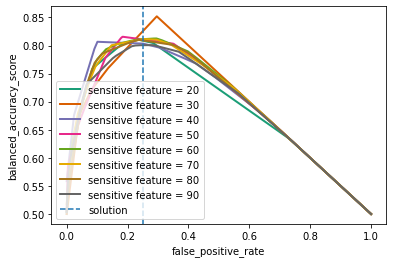

,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,22,1.0,0.25,0.875
30,52,0.75,0.1875,0.78125
40,89,0.25,0.2,0.525
50,274,0.836735,0.235556,0.80059
60,500,0.872093,0.219807,0.826143
70,549,0.931034,0.256351,0.837342
80,435,0.903226,0.198391,0.852417
90,167,0.935484,0.338235,0.798624


0.25

{'20': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4476750591993332],
  'operation1': [>0.4476750591993332]},
 '30': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.3953614609034525],
  'operation1': [>0.3953614609034525]},
 '40': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.469853645503521],
  'operation1': [>0.469853645503521]},
 '50': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.44946852716693175],
  'operation1': [>0.44946852716693175]},
 '60': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.44201817085374806],
  'operation1': [>0.44201817085374806]},
 '70': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4286831874380407],
  'operation1': [>0.4286831874380407]},
 '80': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4489429837431925],
  'operation1': [>0.4489429837431925]},
 '90': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.3754235624879598],
  'operation1': [>0.3754235624879598]}}

In [7]:
# Get data from best run in cv - note no smote on train data 
stays = hold_out_data['stay_id'].unique()
random.Random(25).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

mf_deterministic, eo_ratio_deterministic, fair_est_deterministic, fair_dict_deterministic, mf, eo_ratio, fair_est, fair_dict = fairness_fun(hold_out_data, train_data, test_data, 'anchor_age', "false_positive_rate_parity")
plot_threshold_optimizer(fair_est)
mf_deterministic
eo_ratio_deterministic
fair_dict_deterministic

### Treatment day

In [10]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

stays = hold_out_data['stay_id'].unique()
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

In [11]:
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.load_state_dict(torch.load('hold_out_switch_model_long.pt'))

# Define dataloader and batch size 
batch_size = 256

# Define loss
criterion = nn.BCEWithLogitsLoss()

<All keys matched successfully>

In [12]:
treatment_length_df = pd.DataFrame()

for i in test_data.iv_treatment_length.unique():
    print(i)
    temp_test_data = test_data[test_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])

    temp_test_dataset = MIMICDataset(temp_test_data)
    temp_test_dataloader = DataLoader(dataset=temp_test_dataset, batch_size=batch_size, collate_fn=temp_test_dataset.collate_fn_padd)

    test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, temp_test_dataloader, criterion)

    # Use new cut off
    lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))
    print(np.unique(upper_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]

    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

0


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars


(array([0.], dtype=float32), array([652]))
(array([0, 1]), array([637,  15]))
(array([0, 1]), array([650,   2]))
1


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


(array([0., 1.], dtype=float32), array([573,  17]))
(array([0, 1]), array([521,  69]))
(array([0, 1]), array([578,  12]))
2


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


(array([0., 1.], dtype=float32), array([289,  62]))
(array([0, 1]), array([146, 205]))
(array([0, 1]), array([306,  45]))
3


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


(array([0., 1.], dtype=float32), array([136,  50]))
(array([0, 1]), array([ 23, 163]))
(array([0, 1]), array([111,  75]))
4


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


(array([0., 1.], dtype=float32), array([84, 14]))
(array([0, 1]), array([ 3, 95]))
(array([0, 1]), array([45, 53]))
5


100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


(array([0., 1.], dtype=float32), array([48, 12]))
(array([0, 1]), array([ 4, 56]))
(array([0, 1]), array([20, 40]))
6


100%|██████████| 1/1 [00:00<00:00, 30.33it/s]


(array([0., 1.], dtype=float32), array([28,  4]))
(array([1]), array([32]))
(array([0, 1]), array([ 9, 23]))
999


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
y_pred contains classes not in y_true
invalid value encountered in long_scalars


(array([1.], dtype=float32), array([218]))
(array([0, 1]), array([  3, 215]))
(array([0, 1]), array([ 50, 168]))
7


100%|██████████| 1/1 [00:00<00:00, 53.64it/s]


(array([0., 1.], dtype=float32), array([13,  3]))
(array([1]), array([16]))
(array([0, 1]), array([ 2, 14]))
8


100%|██████████| 1/1 [00:00<00:00, 260.77it/s]

(array([1.], dtype=float32), array([3]))
(array([1]), array([3]))
(array([0, 1]), array([1, 2]))



y_pred contains classes not in y_true
invalid value encountered in long_scalars


In [13]:
treatment_length_df

,Proir days cumulative IV treatment length,Continue with IV,Switch to PO,prediction_0,prediction_1,auroc,balanced_accuracy,accuracy,...,ub_accuracy,ub_recall,ub_precision,ub_f1,ub_auprc,ub_cm,ub_tpr,ub_fpr
0,0,652,0,637,15,NaN,0.976994,0.976994,...,0.996933,0.000000,0.000000,0.000000,NaN,"[[650, 2], [0, 0]]",NaN,0.003067
1,1,573,17,521,69,0.621497,0.621497,0.874576,...,0.954237,0.058824,0.083333,0.068966,0.032021,"[[562, 11], [16, 1]]",0.058824,0.019197
2,2,289,62,146,205,0.635060,0.635060,0.524217,...,0.746439,0.145161,0.200000,0.168224,0.180029,"[[253, 36], [53, 9]]",0.145161,0.124567
3,3,136,50,23,163,0.529853,0.529853,0.349462,...,0.672043,0.640000,0.426667,0.512000,0.369841,"[[93, 43], [18, 32]]",0.640000,0.316176
4,4,84,14,3,95,0.517857,0.517857,0.173469,...,0.581633,0.928571,0.245283,0.388060,0.237967,"[[44, 40], [1, 13]]",0.928571,0.476190
5,5,48,12,4,56,0.489583,0.489583,0.233333,...,0.466667,0.833333,0.250000,0.384615,0.241667,"[[18, 30], [2, 10]]",0.833333,0.625000
6,6,28,4,0,32,0.500000,0.500000,0.125000,...,0.343750,0.750000,0.130435,0.222222,0.129076,"[[8, 20], [1, 3]]",0.750000,0.714286
8,7,13,3,0,16,0.500000,0.500000,0.187500,...,0.187500,0.666667,0.142857,0.235294,0.157738,"[[1, 12], [1, 2]]",0.666667,0.923077
9,8,0,3,0,3,NaN,1.000000,1.000000,...,0.666667,0.666667,1.000000,0.800000,1.000000,"[[0, 0], [1, 2]]",0.666667,NaN
7,PO,0,218,3,215,NaN,0.986239,0.986239,...,0.770642,0.770642,1.000000,0.870466,1.000000,"[[0, 0], [50, 168]]",0.770642,NaN


In [14]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

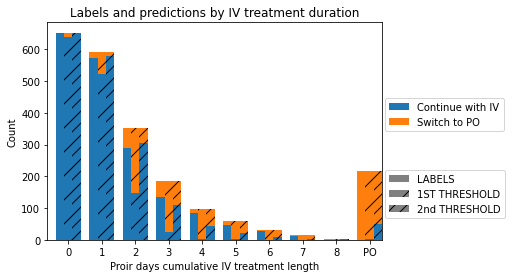

In [15]:
plot_clustered_stacked([df1, df2, df3],["LABELS", "1ST THRESHOLD", "2nd THRESHOLD"], title="Labels and predictions by IV treatment duration",  H="/")

### Antibiotic spectrum

In [16]:
mimic_data = pd.read_csv('mimic_data.csv')
antibiotics_df, antibiotics_value_counts = specific_antibiotics(mimic_data)
antibiotics_df = calculate_asi(antibiotics_df)

Mean iv_asi: 8.245245901639345
STD iv_asi: 2.8163701756686086
Mean po_asi: 5.888524590163934
STD po_asi: 2.5915075797010823
Mean % ASI change: -23.035806634167216
STD % ASI change: 41.320415614145084
Percentage who decrease ASI: 70.0327868852459
Mean iv_asi for those who decrease: 9.00561797752809
STD iv_asi for those who decrease: 2.6181484497099667
Mean po_asi for those who decrease: 5.317415730337078
STD po_asi for those who decrease: 2.516933479461367
Mean % ASI change for those who decrease: -41.317439842720724
STD % ASI change for those who decrease: 20.42237169799019


In [17]:
# Mean iv_asi
Mean_iv_asi = antibiotics_df['iv_asi'].mean()
STD_iv_asi = antibiotics_df['iv_asi'].std()
# Mean po_asi
Mean_po_asi = antibiotics_df['po_asi'].mean()
STD_po_asi = antibiotics_df['po_asi'].std()
# Mean % ASI change
Mean_percentage_ASI_change = antibiotics_df['%_change_asi'].mean()
STD_percentage_ASI_change = antibiotics_df['%_change_asi'].std()
# Percentage decreasing ASI
Percentage_of_patients_who_decrease_ASI = (len(antibiotics_df[antibiotics_df['decrease_asi'] == True])/len(antibiotics_df))*100

In [18]:
# Create lists for the plot
names = ['Mean IV \n ASI', 'Mean PO \n ASI', 'Mean ASI \n decrease', 'Patients who \n decrease']
x_pos = np.arange(len(names))
asi_means = [Mean_iv_asi, Mean_po_asi, np.nan, np.nan]
percentage_means = [np.nan, np.nan, abs(Mean_percentage_ASI_change), Percentage_of_patients_who_decrease_ASI]
asi_error = [STD_iv_asi, STD_po_asi,np.nan,np.nan]
percentage_error = [np.nan, np.nan, STD_percentage_ASI_change, np.nan]

[Text(0, 0, 'Mean IV \n ASI'),
 Text(1, 0, 'Mean PO \n ASI'),
 Text(2, 0, 'Mean ASI \n decrease'),
 Text(3, 0, 'Patients who \n decrease')]

Text(0, 0.5, 'Antibiotic spectrum index (ASI)')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'MIMIC dataset ASI results')

(0.0, 14.0)

(0.0, 100.0)

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

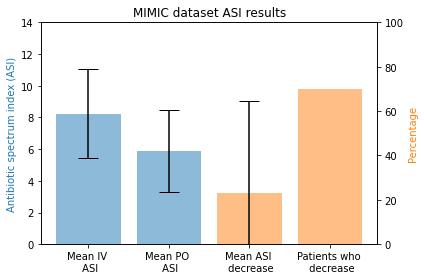

In [19]:
# Build the plot
fig, ax = plt.subplots()

color = 'tab:blue'
color2 = 'tab:orange'

par1 = ax.twinx()
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_ylabel('Antibiotic spectrum index (ASI)', color=color)
par1.set_ylabel("Percentage", color=color2)
ax.set_title('MIMIC dataset ASI results')

ax.set_ylim(0, 14)
par1.set_ylim(0, 100)

ax.bar(x_pos, asi_means, yerr=asi_error, color=color, align='center', alpha=0.5, ecolor='black', capsize=10)
par1.bar(x_pos, percentage_means, yerr=percentage_error, color=color2, align='center', alpha=0.5, ecolor='black', capsize=10)

# Save the figure and show
plt.tight_layout()
plt.show()

### Bad bioavailability

In [20]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [21]:
# Define antibiotics with bad bioavailability
pattern = 'Azithromycin|Ciprofloxacin|Cefpodoxime|Clindamycin|Amoxicillin|Clarithromycin|Nitrofurantoin|Ampicillin|Erythromycin|Penicillin|DiCLOXacillin|Tetracycline|Neomycin|Augmentin|flucloxacillin'

In [22]:
antibiotics_df, antibiotics_value_counts = specific_antibiotics(hold_out_data)
# Filter for those patients with bad bioavailability drugs
filtered_antibiotics_df = antibiotics_df[antibiotics_df['po_antibiotics'].str.contains(pattern, case=False, na=False)]
# Define stay list
bad_bio_stay_id_list = filtered_antibiotics_df.stay_id.unique()

In [23]:
# Run bad bio long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = bad_bio_run_fun(data_dict, model, 'long', bad_bio_stay_id_list)

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Test AUROC result: 0.7781954887218044
Test AUROC result 2: 0.7722431077694235


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Test AUROC result: 0.7567411402157165
Test AUROC result 2: 0.7779275808936825


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Test AUROC result: 0.7720941213504369
Test AUROC result 2: 0.7720941213504369


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]


Test AUROC result: 0.729816702708269
Test AUROC result 2: 0.7169961898877563


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


Test AUROC result: 0.7988402206958676
Test AUROC result 2: 0.7928161243103253


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Test AUROC result: 0.7437264046191429
Test AUROC result 2: 0.7481123695314233


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


Test AUROC result: 0.7701012815212896
Test AUROC result 2: 0.7616267052501033


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Test AUROC result: 0.7782805429864252
Test AUROC result 2: 0.7895927601809953


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Test AUROC result: 0.8064948108470036
Test AUROC result 2: 0.8016404419149648


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Test AUROC result: 0.7487050029506263
Test AUROC result 2: 0.7520490459641991


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


In [24]:
# Save 
with open("bad_bio_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("bad_bio_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [25]:
analyze_results_fun(test_results)

mean test_auroc: 0.7685098447053311
std test_auroc: 0.023741205112284208
test_auroc 2.5th percentile: 0.7239973303075814
test_auroc 97.5th percentile: 0.7996549704539209
mean test_accuracy: 0.7600187753717069
std test_accuracy: 0.029028030093168282
test_accuracy 2.5th percentile: 0.7027000677419946
test_accuracy 97.5th percentile: 0.7932565789473683
mean test_balanced_accuracy: 0.7685098447053311
std test_balanced_accuracy: 0.02374120511228422
test_balanced_accuracy 2.5th percentile: 0.7239973303075813
test_balanced_accuracy 97.5th percentile: 0.7996549704539209
mean test_recall: 0.8211422352806304
std test_recall: 0.05694566221576176
test_recall 2.5th percentile: 0.7158798915605846
test_recall 97.5th percentile: 0.8892669830169829
mean test_precision: 0.6816111862552467
std test_precision: 0.04951885081424146
test_precision 2.5th percentile: 0.5989191017316018
test_precision 97.5th percentile: 0.7583472978634269
mean test_f1: 0.7419723799327179
std test_f1: 0.026733890419153774
test_f

In [26]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7278147632971648
std test_auroc: 0.03311942570479016
test_auroc 2.5th percentile: 0.6628538388966775
test_auroc 97.5th percentile: 0.7702331025933156
mean test_accuracy: 0.7523097157653866
std test_accuracy: 0.027568762265724897
test_accuracy 2.5th percentile: 0.7042557069942229
test_accuracy 97.5th percentile: 0.7928363752122242
mean test_balanced_accuracy: 0.7278147632971648
std test_balanced_accuracy: 0.03311942570479013
test_balanced_accuracy 2.5th percentile: 0.6628538388966775
test_balanced_accuracy 97.5th percentile: 0.7702331025933156
mean test_recall: 0.5715787772828083
std test_recall: 0.08900654259781328
test_recall 2.5th percentile: 0.4163896746817539
test_recall 97.5th percentile: 0.6816699123661148
mean test_precision: 0.7942096088947886
std test_precision: 0.08967118834471198
test_precision 2.5th percentile: 0.6722880061115355
test_precision 97.5th percentile: 0.9439423076923077
mean test_f1: 0.6564626256044441
std test_f1: 0.05626373411622366
test_f1 

In [27]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.591667,0.591667,0.300000,0.116667
"(anchor_age, 30)",0.800000,0.800000,0.714286,0.114286
"(anchor_age, 40)",0.759921,0.759921,0.666667,0.146825
"(anchor_age, 50)",0.800882,0.800882,0.817100,0.215336
"(anchor_age, 60)",0.725253,0.725253,0.770395,0.319890
"(anchor_age, 70)",0.772654,0.772654,0.799346,0.254039
"(anchor_age, 80)",0.790156,0.790156,0.863307,0.282996
"(anchor_age, 90)",0.786947,0.786947,0.790866,0.216971
"(gender, F)",0.779259,0.779259,0.820829,0.262312
"(gender, M)",0.763067,0.763067,0.806366,0.280232


In [28]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.162447,0.162447,0.447214,0.162447
"(anchor_age, 30)",0.170783,0.170783,0.393398,0.195180
"(anchor_age, 40)",0.228562,0.228562,0.416667,0.259509
"(anchor_age, 50)",0.114776,0.114776,0.207411,0.147857
"(anchor_age, 60)",0.045869,0.045869,0.098156,0.144773
"(anchor_age, 70)",0.053094,0.053094,0.139166,0.157571
"(anchor_age, 80)",0.056051,0.056051,0.040197,0.104920
"(anchor_age, 90)",0.098688,0.098688,0.183213,0.118930
"(gender, F)",0.039246,0.039246,0.075383,0.100025
"(gender, M)",0.035958,0.035958,0.061142,0.068126


### eICU

In [31]:
eicu_data = pd.read_csv('eicu_data.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
eicu_data2 = eicu_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [33]:
# Split eICU
eicu_data_dict, eicu_random_x_list = data_fun(eicu_data2, individual, n_cv=10)

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [34]:
# Run long model cv
test_results, ub_test_results = eicu_run_fun(eicu_data_dict, model, 'long')

100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Test AUROC result: 0.7011752747601805
Test AUROC result 2: 0.706047900387523
UPDATED BEST OVERALL MODEL


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


Test AUROC result: 0.7034691557153812
Test AUROC result 2: 0.6996747666516829


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test AUROC result: 0.7143773726140191
Test AUROC result 2: 0.7161551622734321
UPDATED BEST OVERALL MODEL


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Test AUROC result: 0.7545016077170419
Test AUROC result 2: 0.7541479099678456
UPDATED BEST OVERALL MODEL


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Test AUROC result: 0.7390636681416823
Test AUROC result 2: 0.7418924652967206


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Test AUROC result: 0.7368673700379982
Test AUROC result 2: 0.7458666828361226


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Test AUROC result: 0.7187037037037037
Test AUROC result 2: 0.7199074074074074


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Test AUROC result: 0.7191265293479945
Test AUROC result 2: 0.6949589592690104


100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Test AUROC result: 0.7161411984066446
Test AUROC result 2: 0.714975845410628


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Test AUROC result: 0.6895410414827889
Test AUROC result 2: 0.6901762550482762


In [35]:
# Save 
with open("eicu_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("eicu_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [36]:
analyze_results_fun(test_results)

mean test_auroc: 0.7183803354548648
std test_auroc: 0.02110102153561152
test_auroc 2.5th percentile: 0.6912523634979414
test_auroc 97.5th percentile: 0.752284633863208
mean test_accuracy: 0.7480104712849437
std test_accuracy: 0.024131196782814876
test_accuracy 2.5th percentile: 0.7156834374924008
test_accuracy 97.5th percentile: 0.7980454996409704
mean test_balanced_accuracy: 0.7183803354548648
std test_balanced_accuracy: 0.021101021535611515
test_balanced_accuracy 2.5th percentile: 0.6912523634979414
test_balanced_accuracy 97.5th percentile: 0.752284633863208
mean test_recall: 0.6736738689574631
std test_recall: 0.06737125127519229
test_recall 2.5th percentile: 0.5585368839914294
test_recall 97.5th percentile: 0.7711666666666667
mean test_precision: 0.359584784321709
std test_precision: 0.060334516663523595
test_precision 2.5th percentile: 0.28426602924634425
test_precision 97.5th percentile: 0.4770910997204101
mean test_f1: 0.46358705480589013
std test_f1: 0.04484664353555717
test_f1

In [37]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.6352712283266373
std test_auroc: 0.060813179955486726
test_auroc 2.5th percentile: 0.5114651229273871
test_auroc 97.5th percentile: 0.6960189195815626
mean test_accuracy: 0.8422435001335746
std test_accuracy: 0.01911016340459734
test_accuracy 2.5th percentile: 0.8128637849084625
test_accuracy 97.5th percentile: 0.8750985843048888
mean test_balanced_accuracy: 0.6352712283266373
std test_balanced_accuracy: 0.06081317995548671
test_balanced_accuracy 2.5th percentile: 0.5114651229273871
test_balanced_accuracy 97.5th percentile: 0.6960189195815626
mean test_recall: 0.32852042815270993
std test_recall: 0.1462218007680072
test_recall 2.5th percentile: 0.028333333333333332
test_recall 97.5th percentile: 0.4575657894736842
mean test_precision: 0.4763922177333961
std test_precision: 0.17181818420217337
test_precision 2.5th percentile: 0.09302884615384616
test_precision 97.5th percentile: 0.6381638714185884
mean test_f1: 0.37857788644606294
std test_f1: 0.1533778995231147
test_

In [38]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in eicu_data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
np.array(test_data_pr_ratio_list).mean()

0.16302460172477629

Distribution

In [39]:
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

eicu_data = pd.read_csv('eicu_data.csv')

In [40]:
# Group mimic
grouped_mimic = hold_out_data.groupby('iv_treatment_length').po_flag.value_counts()
grouped_mimic2 = pd.pivot(pd.DataFrame(grouped_mimic).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_mimic2 = grouped_mimic2.droplevel('po_flag', axis=1)
grouped_mimic2.reset_index(inplace=True)
grouped_mimic2.columns = ['iv_treatment_length', 'label_0', 'label_1']
# Set to string
grouped_mimic2['iv_treatment_length']= grouped_mimic2['iv_treatment_length'].astype(str)
# Change 999
grouped_mimic2['iv_treatment_length'] = grouped_mimic2['iv_treatment_length'].replace(['999'], 'PO')
grouped_mimic2.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length'}, inplace=True)
# Change to %
grouped_mimic2.fillna(0, inplace=True)
grouped_mimic2['Continue with IV'] = grouped_mimic2['label_0']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100
grouped_mimic2['Switch to PO'] = grouped_mimic2['label_1']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100

In [41]:
# Group eicu
grouped_eicu = eicu_data.groupby('iv_treatment_length').po_flag.value_counts()
grouped_eicu2 = pd.pivot(pd.DataFrame(grouped_eicu).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_eicu2 = grouped_eicu2.droplevel('po_flag', axis=1)
grouped_eicu2.reset_index(inplace=True)
grouped_eicu2.columns = ['iv_treatment_length', 'label_0', 'label_1']
# Set to string
grouped_eicu2['iv_treatment_length']= grouped_eicu2['iv_treatment_length'].astype(str)
# Change 999
grouped_eicu2['iv_treatment_length'] = grouped_eicu2['iv_treatment_length'].replace(['999'], 'PO')
grouped_eicu2.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length'}, inplace=True)
# Change to %
grouped_eicu2.fillna(0, inplace=True)
grouped_eicu2['Continue with IV'] = grouped_eicu2['label_0']/(grouped_eicu2['label_0']+grouped_eicu2['label_1'])*100
grouped_eicu2['Switch to PO'] = grouped_eicu2['label_1']/(grouped_eicu2['label_0']+grouped_eicu2['label_1'])*100

In [42]:
df1 = grouped_mimic2[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = grouped_eicu2[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'MIMIC and eICU labels by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

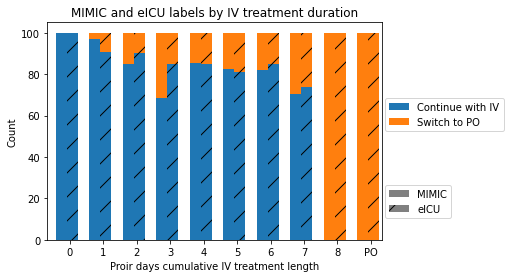

In [43]:
plot_clustered_stacked([df1, df2],["MIMIC", "eICU"], title="MIMIC and eICU labels by IV treatment duration",  H="/")

In [48]:
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
eicu_data = eicu_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

X_data = eicu_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
eicu_model_data = pd.concat([eicu_data[['stay_id', 'po_flag', 'iv_treatment_length']], X_data], axis=1)

<All keys matched successfully>

0


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars


(array([0.], dtype=float32), array([1633]))
(array([0, 1]), array([1588,   45]))
(array([0, 1]), array([1622,   11]))
1


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


(array([0., 1.], dtype=float32), array([1161,  121]))
(array([0, 1]), array([1118,  164]))
(array([0, 1]), array([1261,   21]))
999


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
y_pred contains classes not in y_true
invalid value encountered in long_scalars


(array([1.], dtype=float32), array([515]))
(array([0, 1]), array([ 96, 419]))
(array([0, 1]), array([300, 215]))
2


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


(array([0., 1.], dtype=float32), array([665,  71]))
(array([0, 1]), array([382, 354]))
(array([0, 1]), array([703,  33]))
3


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


(array([0., 1.], dtype=float32), array([329,  58]))
(array([0, 1]), array([ 92, 295]))
(array([0, 1]), array([337,  50]))
4


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


(array([0., 1.], dtype=float32), array([171,  30]))
(array([0, 1]), array([ 21, 180]))
(array([0, 1]), array([142,  59]))
5


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


(array([0., 1.], dtype=float32), array([85, 20]))
(array([0, 1]), array([ 7, 98]))
(array([0, 1]), array([65, 40]))
6


100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


(array([0., 1.], dtype=float32), array([50,  9]))
(array([0, 1]), array([ 2, 57]))
(array([0, 1]), array([32, 27]))
7


100%|██████████| 1/1 [00:00<00:00, 45.88it/s]


(array([0., 1.], dtype=float32), array([17,  6]))
(array([0, 1]), array([ 1, 22]))
(array([0, 1]), array([13, 10]))
8


100%|██████████| 1/1 [00:00<00:00, 140.41it/s]

(array([1.], dtype=float32), array([6]))
(array([1]), array([6]))
(array([0, 1]), array([3, 3]))



y_pred contains classes not in y_true
invalid value encountered in long_scalars


<AxesSubplot:title={'center':'eICU Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

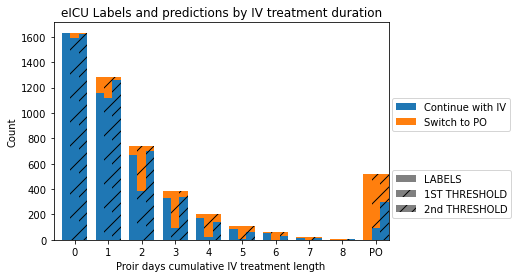

In [104]:
model.load_state_dict(torch.load('eicu_switch_model_long.pt'))
treatment_length_df = pd.DataFrame()

for i in eicu_model_data.iv_treatment_length.unique():
    print(i)
    temp_test_data = eicu_model_data[eicu_model_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])

    temp_test_dataset = MIMICDataset(temp_test_data)
    temp_test_dataloader = DataLoader(dataset=temp_test_dataset, batch_size=batch_size, collate_fn=temp_test_dataset.collate_fn_padd)

    test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, temp_test_dataloader, criterion)

    # Use new cut off
    lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))
    print(np.unique(upper_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]

    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)
# Get dfs
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])
# Plot
plot_clustered_stacked([df1, df2, df3],["LABELS", "1ST THRESHOLD", "2nd THRESHOLD"], title="eICU Labels and predictions by IV treatment duration",  H="/")

### Bad absorption

In [55]:
# Look at results in those with bad absorption
# 225916 = TPN w/ Lipids
# 225917 = TPN without Lipids

In [56]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)

In [57]:
# First look at other iv input events in icu
stays = hold_out_data['stay_id'].unique()
inputevents = pd.read_csv('mimic-iv-2.0/icu/inputevents.csv')
inputevents = inputevents[inputevents['stay_id'].isin(stays)]
inputevents = inputevents[['stay_id', 'itemid', 'starttime', 'endtime']]
inputevents['starttime'] = pd.to_datetime(inputevents['starttime']).dt.date
inputevents['endtime'] = pd.to_datetime(inputevents['endtime']).dt.date
# Filter for TPN
inputevents = inputevents[(inputevents['itemid'] == 225916)|(inputevents['itemid'] == 225917)]
inputevents.drop_duplicates(inplace=True)

In [58]:
dates = inputevents.copy()
dates['date'] = dates.apply(lambda x:
    pd.date_range(start=x['starttime'],
                end=x['endtime'],
                #inclusive='both',
                freq='D'), axis=1)
dates = dates.explode('date')
dates['date'] = dates['date'].astype(str)
dates['TPN'] = 1
dates = dates[['stay_id', 'date', 'TPN']]
new_hold_out_data = pd.merge(hold_out_data[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag']], dates, how='left')#, on=['stay_id', 'date'])
new_hold_out_data.drop_duplicates(inplace=True)
# Get list of stays
tpn_stay_list = new_hold_out_data[new_hold_out_data['TPN'] == 1].stay_id.unique().tolist()
# Filter data
#filtered_new_hold_out_data = new_hold_out_data[new_hold_out_data['stay_id'].isin(tpn_stay_list)]

In [59]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

data_dict, random_x_list = bad_abs_data_fun(tpn_stay_list, hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

[2, 7, 15, 22, 35, 36, 43, 47, 48, 50]

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [60]:
# Run bad bio long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = bad_abs_run_fun(data_dict, model, 'long', tpn_stay_list)

100%|██████████| 1/1 [00:00<00:00, 49.39it/s]


Test AUROC result: 0.7833333333333334
Test AUROC result 2: 0.7833333333333334


100%|██████████| 1/1 [00:00<00:00, 139.02it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 183.77it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 92.83it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 151.18it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 160.89it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 133.22it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 126.64it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 146.43it/s]
y_pred contains classes not in y_true
invalid value encountered i

Test AUROC result: 0.7285714285714286
Test AUROC result 2: 0.7285714285714286


100%|██████████| 1/1 [00:00<00:00, 96.91it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 253.83it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 241.75it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 141.24it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 97.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 25.55it/s]


Test AUROC result: 0.8076923076923077
Test AUROC result 2: 0.8076923076923077


100%|██████████| 1/1 [00:00<00:00, 99.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 267.56it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 143.01it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 103.00it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 156.60it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Test AUROC result: 0.75
Test AUROC result 2: 0.75


100%|██████████| 1/1 [00:00<00:00, 54.76it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 297.49it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 138.54it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 285.39it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 93.71it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 144.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 104.51it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 140.79it/s]
y_pred contains classes not in y_true
invalid value encountered in

Test AUROC result: 0.8
Test AUROC result 2: 0.8


100%|██████████| 1/1 [00:00<00:00, 180.41it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 178.63it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 152.34it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 270.65it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 186.61it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 42.09it/s]


Test AUROC result: 0.782608695652174
Test AUROC result 2: 0.782608695652174


100%|██████████| 1/1 [00:00<00:00, 97.77it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 279.38it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 104.00it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 80.51it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 81.35it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 228.36it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 161.91it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 160.48it/s]
y_pred contains classes not in y_true
invalid value encountered in 

Test AUROC result: 0.6666666666666667
Test AUROC result 2: 0.6666666666666667


100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


Test AUROC result: 0.6571428571428573
Test AUROC result 2: 0.6571428571428573


100%|██████████| 1/1 [00:00<00:00, 195.28it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 138.07it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 230.38it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 262.34it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 125.70it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 97.33it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 119.32it/s]


Test AUROC result: 0.8571428571428572
Test AUROC result 2: 0.8571428571428572


100%|██████████| 1/1 [00:00<00:00, 177.03it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 258.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 349.76it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 342.92it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 273.82it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 269.68it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 195.35it/s]


Test AUROC result: 0.6666666666666667
Test AUROC result 2: 0.6666666666666667


100%|██████████| 1/1 [00:00<00:00, 216.75it/s]


In [61]:
# Save 
with open("bad_abs_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("bad_abs_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [62]:
analyze_results_fun(test_results)

mean test_auroc: 0.7499824812868293
std test_auroc: 0.06515592898558258
test_auroc 2.5th percentile: 0.6592857142857144
test_auroc 97.5th percentile: 0.8460164835164836
mean test_accuracy: 0.6525224775224775
std test_accuracy: 0.10362608043553262
test_accuracy 2.5th percentile: 0.5
test_accuracy 97.5th percentile: 0.7592261904761904
mean test_balanced_accuracy: 0.7499824812868291
std test_balanced_accuracy: 0.06515592898558262
test_balanced_accuracy 2.5th percentile: 0.6592857142857143
test_balanced_accuracy 97.5th percentile: 0.8460164835164836
mean test_recall: 0.9290476190476191
std test_recall: 0.1256357980095506
test_recall 2.5th percentile: 0.6525
test_recall 97.5th percentile: 1
mean test_precision: 0.3893900543900545
std test_precision: 0.15768226077517689
test_precision 2.5th percentile: 0.12237762237762238
test_precision 97.5th percentile: 0.59625
mean test_f1: 0.5255325814536341
std test_f1: 0.17000117786780694
test_f1 2.5th percentile: 0.21354166666666669
test_f1 97.5th per

In [63]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7069636884854276
std test_auroc: 0.1581649592820254
test_auroc 2.5th percentile: 0.5021428571428571
test_auroc 97.5th percentile: 0.9775
mean test_accuracy: 0.7851302863802865
std test_accuracy: 0.10365909955453553
test_accuracy 2.5th percentile: 0.6126420454545455
test_accuracy 97.5th percentile: 0.9740384615384615
mean test_balanced_accuracy: 0.7069636884854276
std test_balanced_accuracy: 0.1581649592820254
test_balanced_accuracy 2.5th percentile: 0.5021428571428571
test_balanced_accuracy 97.5th percentile: 0.9775
mean test_recall: 0.5328571428571428
std test_recall: 0.33894895568185945
test_recall 2.5th percentile: 0.06428571428571428
test_recall 97.5th percentile: 1
mean test_precision: 0.5650000000000001
std test_precision: 0.35437346903451383
test_precision 2.5th percentile: 0.045000000000000005
test_precision 97.5th percentile: 1
mean test_f1: 0.47658730158730167
std test_f1: 0.26357673810424714
test_f1 2.5th percentile: 0.05625
test_f1 97.5th percentile: 0.93

In [64]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        # Filter for bad bio
        test_data = test_data[test_data['stay_id'].isin(tpn_stay_list)]
        if len(test_data.po_flag.value_counts(normalize=True)) == 2:
                test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
        else:
                test_data_pr_ratio_list.append(0.0)
np.array(test_data_pr_ratio_list).mean()

0.23092074592074593

In [65]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 30)",0.666667,NaN,NaN,0.333333
"(anchor_age, 40)",0.533333,0.666667,0.333333,0.300000
"(anchor_age, 50)",0.626984,0.714286,1.000000,0.468254
"(anchor_age, 60)",1.000000,1.000000,1.000000,0.000000
"(anchor_age, 70)",0.757937,0.855820,0.916667,0.287698
"(anchor_age, 80)",0.722457,0.747619,1.000000,0.435281
"(gender, F)",0.771163,0.771163,0.888095,0.345769
"(gender, M)",0.599580,0.852941,1.000000,0.418803
"(grouped_race, ASIAN)",0.700000,0.700000,1.000000,0.600000
"(grouped_race, BLACK)",0.753401,0.753401,0.935374,0.428571


In [66]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 30)",0.000000,NaN,NaN,0.000000
"(anchor_age, 40)",0.188562,NaN,NaN,0.424264
"(anchor_age, 50)",0.112519,NaN,NaN,0.122181
"(anchor_age, 60)",NaN,NaN,NaN,NaN
"(anchor_age, 70)",0.223242,0.152552,0.139443,0.251717
"(anchor_age, 80)",0.079425,0.080478,0.000000,0.159376
"(gender, F)",0.115148,0.115148,0.218232,0.263511
"(gender, M)",0.174037,NaN,NaN,0.149488
"(grouped_race, ASIAN)",NaN,NaN,NaN,NaN
"(grouped_race, BLACK)",0.094500,0.094500,0.115596,0.260646


### Type of infection

In [67]:
# Look at results in different types of infections 

In [68]:
# Import diagnosis
diagnoses_icd = pd.read_csv(r"mimic-iv-2.0/hosp/diagnoses_icd.csv")
d_icd_diagnoses = pd.read_csv(r"mimic-iv-2.0/hosp/d_icd_diagnoses.csv")

# Filter by uti
uti_d_icd_diagnoses = d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.contains("urinary tract infection", case=False)) | \
                                  (d_icd_diagnoses['long_title'].str.contains("pyelonephritis", case=False))]

# Filter by pneumonia
pneumonia_d_icd_diagnoses = d_icd_diagnoses[d_icd_diagnoses['long_title'].str.contains("pneumonia", case=False)]

# Filter by spesfic sepsis
sepsis_d_icd_diagnoses = d_icd_diagnoses[(d_icd_diagnoses['icd_code'] == 'A410')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4101')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4102')| \
                                    (d_icd_diagnoses['icd_code'] == 'A411')| \
                                    (d_icd_diagnoses['icd_code'] == 'A412')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4181')| \
                                    (d_icd_diagnoses['icd_code'] == 'P362')| \
                                    (d_icd_diagnoses['icd_code'] == 'P363')| \
                                    (d_icd_diagnoses['icd_code'] == 'P3630')| \
                                    (d_icd_diagnoses['icd_code'] == 'P3639')]
#diagnoses_icd = pd.merge(diagnoses_icd, d_icd_diagnoses, how='inner', on='icd_code')

In [69]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)

In [70]:
# Get subject_id and hadm_id
icu_stays = pd.read_csv(r"mimic-iv-2.0/icu/icustays.csv")

hold_out_stays = hold_out_data.stay_id.unique().tolist()

icu_stays = icu_stays[icu_stays['stay_id'].isin(hold_out_stays)]

In [71]:
diagnoses = pd.merge(diagnoses_icd, icu_stays[['subject_id', 'hadm_id', 'stay_id']])
uti_diagnoses = pd.merge(diagnoses, uti_d_icd_diagnoses)
pneumonia_diagnoses = pd.merge(diagnoses, pneumonia_d_icd_diagnoses)
sepsis_diagnoses = pd.merge(diagnoses, sepsis_d_icd_diagnoses)

In [72]:
uti_stays = uti_diagnoses.stay_id.unique().tolist()
pneumonia_stays = pneumonia_diagnoses.stay_id.unique().tolist()
sepsis_stays = sepsis_diagnoses.stay_id.unique().tolist()

In [73]:
len(uti_stays)
len(pneumonia_stays)
len(sepsis_stays)

691

1158

43

UTI

In [74]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [75]:
# Run long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'long', uti_stays)

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Test AUROC result: 0.8133802816901409
Test AUROC result 2: 0.8080985915492959


100%|██████████| 1/1 [00:00<00:00, 221.34it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 272.62it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 218.36it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


Test AUROC result: 0.784275850731547
Test AUROC result 2: 0.7876869965477561


100%|██████████| 1/1 [00:00<00:00, 213.07it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 119.99it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 139.51it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


Test AUROC result: 0.7930937900128042
Test AUROC result 2: 0.7959346991037133


100%|██████████| 1/1 [00:00<00:00, 188.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Test AUROC result: 0.7867063492063491
Test AUROC result 2: 0.7938492063492063


100%|██████████| 1/1 [00:00<00:00, 178.08it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Test AUROC result: 0.7825324675324675
Test AUROC result 2: 0.7857792207792207


100%|██████████| 1/1 [00:00<00:00, 216.70it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 53.72it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 138.43it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Test AUROC result: 0.7691286388670339
Test AUROC result 2: 0.7721774193548387


100%|██████████| 1/1 [00:00<00:00, 178.85it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


Test AUROC result: 0.7677437618797266
Test AUROC result 2: 0.7646095361345897


100%|██████████| 1/1 [00:00<00:00, 118.32it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 58.38it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Test AUROC result: 0.7571514217197672
Test AUROC result 2: 0.7529976019184653


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Test AUROC result: 0.7843847684001137
Test AUROC result 2: 0.7838519465757317


100%|██████████| 1/1 [00:00<00:00, 160.74it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Test AUROC result: 0.7559821057012068
Test AUROC result 2: 0.7587910944652518


100%|██████████| 1/1 [00:00<00:00, 68.40it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 58.66it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 38.30it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 131.27it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


In [76]:
# Save 
with open("uti_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("uti_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [77]:
analyze_results_fun(test_results)

mean test_auroc: 0.780377631277807
std test_auroc: 0.016787355564542406
test_auroc 2.5th percentile: 0.7543011377414923
test_auroc 97.5th percentile: 0.8053617157490398
mean test_accuracy: 0.7211748487447592
std test_accuracy: 0.0272709936171307
test_accuracy 2.5th percentile: 0.6759459036898061
test_accuracy 97.5th percentile: 0.7587605993101466
mean test_balanced_accuracy: 0.780377631277807
std test_balanced_accuracy: 0.016787355564542417
test_balanced_accuracy 2.5th percentile: 0.7543011377414922
test_balanced_accuracy 97.5th percentile: 0.8053617157490397
mean test_recall: 0.8746567902657686
std test_recall: 0.04347820325076141
test_recall 2.5th percentile: 0.7957278481012658
test_recall 97.5th percentile: 0.9290609903381642
mean test_precision: 0.39035450279857276
std test_precision: 0.060602713635860526
test_precision 2.5th percentile: 0.28728362764333987
test_precision 97.5th percentile: 0.44858443708609275
mean test_f1: 0.5363083933079281
std test_f1: 0.05918299687370455
test_f

In [78]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7650399000211695
std test_auroc: 0.04406261474684744
test_auroc 2.5th percentile: 0.6826219922938054
test_auroc 97.5th percentile: 0.8179028336686788
mean test_accuracy: 0.8285693367922213
std test_accuracy: 0.024156835182043798
test_accuracy 2.5th percentile: 0.7808758322708599
test_accuracy 97.5th percentile: 0.8582491382384405
mean test_balanced_accuracy: 0.7650399000211695
std test_balanced_accuracy: 0.04406261474684741
test_balanced_accuracy 2.5th percentile: 0.6826219922938054
test_balanced_accuracy 97.5th percentile: 0.8179028336686788
mean test_recall: 0.6618488304641189
std test_recall: 0.12008098848536577
test_recall 2.5th percentile: 0.4479166666666667
test_recall 97.5th percentile: 0.8236559139784947
mean test_precision: 0.5409395334111302
std test_precision: 0.08602458429436051
test_precision 2.5th percentile: 0.39014805194805197
test_precision 97.5th percentile: 0.6398148148148148
mean test_f1: 0.5833450554477932
std test_f1: 0.06510865541658038
test_f1

In [79]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.856250,0.800000,1.000000,0.310000
"(anchor_age, 30)",0.718825,0.500000,0.000000,0.225620
"(anchor_age, 40)",0.884421,0.861351,1.000000,0.244340
"(anchor_age, 50)",0.778605,0.778605,0.860108,0.302899
"(anchor_age, 60)",0.772773,0.772773,0.864761,0.319216
"(anchor_age, 70)",0.723951,0.723951,0.773442,0.325539
"(anchor_age, 80)",0.787866,0.787866,0.861472,0.285740
"(anchor_age, 90)",0.779104,0.779104,0.834999,0.276791
"(gender, F)",0.779826,0.779826,0.851902,0.292250
"(gender, M)",0.784210,0.784210,0.883558,0.315138


In [80]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.120823,0.000000,0.000000,0.082158
"(anchor_age, 30)",0.121645,NaN,NaN,0.123378
"(anchor_age, 40)",0.101590,0.028463,0.000000,0.088060
"(anchor_age, 50)",0.087451,0.087451,0.160797,0.053444
"(anchor_age, 60)",0.054064,0.054064,0.102924,0.031456
"(anchor_age, 70)",0.086268,0.086268,0.185609,0.084023
"(anchor_age, 80)",0.037257,0.037257,0.078238,0.059000
"(anchor_age, 90)",0.082309,0.082309,0.145015,0.104427
"(gender, F)",0.028828,0.028828,0.077442,0.033922
"(gender, M)",0.044353,0.044353,0.039070,0.076337


Pneumonia

In [81]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [82]:
# Run bad bio long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'long', pneumonia_stays)

100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


Test AUROC result: 0.8052125564693617
Test AUROC result 2: 0.8068110737866327


100%|██████████| 1/1 [00:00<00:00, 185.04it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 94.32it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 28.13it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


Test AUROC result: 0.7905982905982907
Test AUROC result 2: 0.8024326101249177


100%|██████████| 1/1 [00:00<00:00, 66.42it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  6.63it/s]


Test AUROC result: 0.7741561639866723
Test AUROC result 2: 0.7678183398522381


100%|██████████| 1/1 [00:00<00:00, 92.59it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 26.79it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 62.74it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


Test AUROC result: 0.7750726744186047
Test AUROC result 2: 0.7799176356589146


100%|██████████| 1/1 [00:00<00:00, 77.97it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 52.74it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 168.05it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 53.84it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Test AUROC result: 0.7521726892086836
Test AUROC result 2: 0.7572921431335984


100%|██████████| 1/1 [00:00<00:00, 91.76it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


Test AUROC result: 0.7453103288559519
Test AUROC result 2: 0.7462945808244558


100%|██████████| 1/1 [00:00<00:00, 82.11it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 39.38it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 25.53it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 30.40it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 52.43it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 295.33it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 127.90it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
y_pred contains classes not in y_true
invalid value encountered in lon

Test AUROC result: 0.7841730130833822
Test AUROC result 2: 0.7847685998828354


100%|██████████| 1/1 [00:00<00:00, 98.93it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 39.03it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 54.52it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Test AUROC result: 0.7698335624215622
Test AUROC result 2: 0.7655456283989721


100%|██████████| 1/1 [00:00<00:00, 131.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Test AUROC result: 0.7551098064796695
Test AUROC result 2: 0.7517395085888237


100%|██████████| 1/1 [00:00<00:00, 40.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 42.11it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


Test AUROC result: 0.7726739926739927
Test AUROC result 2: 0.7678388278388278


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


In [83]:
# Save 
with open("pneumonia_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("pneumonia_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [84]:
analyze_results_fun(test_results)

mean test_auroc: 0.7730458948090216
std test_auroc: 0.019278950811699547
test_auroc 2.5th percentile: 0.7475196895714386
test_auroc 97.5th percentile: 0.8058259194627468
mean test_accuracy: 0.7022292764744636
std test_accuracy: 0.035607813910830864
test_accuracy 2.5th percentile: 0.6417342854972669
test_accuracy 97.5th percentile: 0.7610364540472397
mean test_balanced_accuracy: 0.7730458948090216
std test_balanced_accuracy: 0.01927895081169954
test_balanced_accuracy 2.5th percentile: 0.7475196895714386
test_balanced_accuracy 97.5th percentile: 0.8058259194627468
mean test_recall: 0.8697265729524544
std test_recall: 0.03073740283586253
test_recall 2.5th percentile: 0.8265469464622006
test_recall 97.5th percentile: 0.9233333333333333
mean test_precision: 0.2967909762207307
std test_precision: 0.05702023835310263
test_precision 2.5th percentile: 0.20028457356439006
test_precision 97.5th percentile: 0.38023151471643934
mean test_f1: 0.43944595404889986
std test_f1: 0.06516720806419078
test

In [85]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.739991702290041
std test_auroc: 0.04215814243023473
test_auroc 2.5th percentile: 0.6754671919497001
test_auroc 97.5th percentile: 0.8022108733191646
mean test_accuracy: 0.8234637986364437
std test_accuracy: 0.03140999715837523
test_accuracy 2.5th percentile: 0.7681179285830448
test_accuracy 97.5th percentile: 0.8714885305718981
mean test_balanced_accuracy: 0.739991702290041
std test_balanced_accuracy: 0.0421581424302347
test_balanced_accuracy 2.5th percentile: 0.6754671919497002
test_balanced_accuracy 97.5th percentile: 0.8022108733191645
mean test_recall: 0.6240466172940854
std test_recall: 0.10329659373868808
test_recall 2.5th percentile: 0.4487560192616372
test_recall 97.5th percentile: 0.7876470588235295
mean test_precision: 0.41135462994141136
std test_precision: 0.09405744191571747
test_precision 2.5th percentile: 0.2564701257861635
test_precision 97.5th percentile: 0.5640986394557823
mean test_f1: 0.48462913585992473
std test_f1: 0.07507471746114448
test_f1 2.

In [86]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.722242,NaN,NaN,0.499965
"(anchor_age, 30)",0.780363,0.729717,0.750000,0.257563
"(anchor_age, 40)",0.784024,0.812940,0.952778,0.327846
"(anchor_age, 50)",0.790761,0.790761,0.916667,0.335145
"(anchor_age, 60)",0.761454,0.761454,0.831356,0.308448
"(anchor_age, 70)",0.770467,0.770467,0.863715,0.322781
"(anchor_age, 80)",0.777651,0.777651,0.840424,0.285121
"(anchor_age, 90)",0.736293,0.736293,0.762262,0.289676
"(gender, F)",0.785502,0.785502,0.872044,0.301040
"(gender, M)",0.761735,0.761735,0.839664,0.316194


In [87]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.291800,NaN,NaN,0.177271
"(anchor_age, 30)",0.145261,0.153642,0.418330,0.114790
"(anchor_age, 40)",0.082453,0.061913,0.096819,0.069603
"(anchor_age, 50)",0.054571,0.054571,0.111880,0.076497
"(anchor_age, 60)",0.063838,0.063838,0.108808,0.056772
"(anchor_age, 70)",0.072216,0.072216,0.123494,0.074917
"(anchor_age, 80)",0.092586,0.092586,0.192734,0.076046
"(anchor_age, 90)",0.117091,0.117091,0.217266,0.045154
"(gender, F)",0.026742,0.026742,0.067356,0.057446
"(gender, M)",0.040665,0.040665,0.065958,0.043176


Sepsis

In [89]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

data_dict, random_x_list = sepsis_data_fun(sepsis_stays, hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

[2, 18, 22, 25, 35, 43, 47, 48, 50, 70]

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [90]:
# Run bad bio long model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'long', sepsis_stays)

100%|██████████| 1/1 [00:00<00:00, 26.68it/s]


Test AUROC result: 0.75
Test AUROC result 2: 0.75


100%|██████████| 1/1 [00:00<00:00, 56.81it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 56.24it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 147.04it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 168.30it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 95.01it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 111.15it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 153.13it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 38.34it/s]


Test AUROC result: 0.7916666666666666
Test AUROC result 2: 0.8333333333333334


100%|██████████| 1/1 [00:00<00:00, 74.93it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 124.56it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 95.80it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 140.41it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 111.73it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 34.25it/s]


Test AUROC result: 0.7010869565217391
Test AUROC result 2: 0.6385869565217391


100%|██████████| 1/1 [00:00<00:00, 181.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 336.46it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 78.03it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 362.48it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 45.13it/s]


Test AUROC result: 0.7611111111111112
Test AUROC result 2: 0.7611111111111112


100%|██████████| 1/1 [00:00<00:00, 91.30it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 173.85it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 136.85it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 40.70it/s]


Test AUROC result: 0.8043478260869565
Test AUROC result 2: 0.8043478260869565


100%|██████████| 1/1 [00:00<00:00, 120.89it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 79.30it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 71.15it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 127.82it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 74.36it/s]


Test AUROC result: 0.775
Test AUROC result 2: 0.775


100%|██████████| 1/1 [00:00<00:00, 167.56it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 179.64it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


Test AUROC result: 0.8125
Test AUROC result 2: 0.8125


100%|██████████| 1/1 [00:00<00:00, 66.00it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 65.99it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 279.84it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 364.22it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 110.04it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 377.25it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 364.18it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 283.67it/s]
y_pred contains classes not in y_true
invalid value encountered in

Test AUROC result: 0.8409090909090909
Test AUROC result 2: 0.8409090909090909


100%|██████████| 1/1 [00:00<00:00, 179.46it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 128.85it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 82.06it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 143.66it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Test AUROC result: 0.625
Test AUROC result 2: 0.6458333333333334


100%|██████████| 1/1 [00:00<00:00, 193.24it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 182.60it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 374.29it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 104.54it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 367.89it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 88.87it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 380.19it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 42.45it/s]


Test AUROC result: 0.8636363636363636
Test AUROC result 2: 0.8636363636363636


100%|██████████| 1/1 [00:00<00:00, 84.97it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 91.46it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 276.20it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 99.15it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 187.88it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 47.00it/s]


In [91]:
# Save 
with open("sepsis_long_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("sepsis_long_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [92]:
analyze_results_fun(test_results)

mean test_auroc: 0.7725258014931927
std test_auroc: 0.07343021636750446
test_auroc 2.5th percentile: 0.6402173913043478
test_auroc 97.5th percentile: 0.8585227272727273
mean test_accuracy: 0.6800347891161355
std test_accuracy: 0.07726728470356678
test_accuracy 2.5th percentile: 0.5375992063492063
test_accuracy 97.5th percentile: 0.7692307692307693
mean test_balanced_accuracy: 0.7725258014931927
std test_balanced_accuracy: 0.07343021636750446
test_balanced_accuracy 2.5th percentile: 0.6402173913043478
test_balanced_accuracy 97.5th percentile: 0.8585227272727273
mean test_recall: 0.8975
std test_recall: 0.13344006145082515
test_recall 2.5th percentile: 0.653125
test_recall 97.5th percentile: 1
mean test_precision: 0.34699373725689514
std test_precision: 0.14260909431360305
test_precision 2.5th percentile: 0.12979323308270677
test_precision 97.5th percentile: 0.6166666666666667
mean test_f1: 0.477405143875732
std test_f1: 0.1388803520445004
test_f1 2.5th percentile: 0.22261904761904763
te

In [93]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7603341761605827
std test_auroc: 0.18052885572601451
test_auroc 2.5th percentile: 0.41322916666666665
test_auroc 97.5th percentile: 0.9545454545454545
mean test_accuracy: 0.7983813171400829
std test_accuracy: 0.10175405049820306
test_accuracy 2.5th percentile: 0.626304945054945
test_accuracy 97.5th percentile: 0.9230769230769231
mean test_balanced_accuracy: 0.7603341761605827
std test_balanced_accuracy: 0.18052885572601451
test_balanced_accuracy 2.5th percentile: 0.4132291666666667
test_balanced_accuracy 97.5th percentile: 0.9545454545454546
mean test_recall: 0.6799999999999999
std test_recall: 0.3272613634390715
test_recall 2.5th percentile: 0.09000000000000001
test_recall 97.5th percentile: 1
mean test_precision: 0.4622222222222222
std test_precision: 0.20645150089602696
test_precision 2.5th percentile: 0.049999999999999996
test_precision 97.5th percentile: 0.6666666666666666
mean test_f1: 0.5201731601731601
std test_f1: 0.22302584962346822
test_f1 2.5th percentile

In [94]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 40)",1.000000,NaN,NaN,NaN
"(anchor_age, 50)",0.673214,0.693750,1.000000,0.507653
"(anchor_age, 60)",0.726311,0.652122,0.587500,0.275379
"(anchor_age, 70)",0.876923,0.800000,1.000000,0.469231
"(anchor_age, 80)",0.710714,0.795000,1.000000,0.435714
"(gender, F)",0.701578,0.533365,0.375000,0.296133
"(gender, M)",0.776906,0.796563,0.955556,0.366187
"(grouped_race, ASIAN)",1.000000,NaN,NaN,NaN
"(grouped_race, OTHER)",0.625000,NaN,NaN,0.500000
"(grouped_race, UNKNOWN)",0.833333,NaN,NaN,0.333333


In [95]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 40)",NaN,NaN,NaN,NaN
"(anchor_age, 50)",0.206225,0.008839,0.000000,0.100264
"(anchor_age, 60)",0.181958,0.228463,0.265754,0.152142
"(anchor_age, 70)",0.218656,NaN,NaN,0.097907
"(anchor_age, 80)",0.180452,0.062249,0.000000,0.146701
"(gender, F)",0.157928,0.028577,0.176777,0.124178
"(gender, M)",0.091425,0.071111,0.088192,0.179755
"(grouped_race, ASIAN)",NaN,NaN,NaN,NaN
"(grouped_race, OTHER)",0.250000,NaN,NaN,0.000000
"(grouped_race, UNKNOWN)",0.235702,NaN,NaN,NaN


### LOS

In [4]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

stays = hold_out_data['stay_id'].unique()
import random
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'date', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
# Filter for relevant durations
test_data = test_data[(test_data['iv_treatment_length'] >= 2) & (test_data['iv_treatment_length'] < 8)]

In [5]:
data_dict, random_x_list = los_data_fun(hold_out_data, individual, n_cv=10)
# Run
po_los_dict, iv_los_dict = los_run_fun(data_dict)

In [6]:
for i in test_data.iv_treatment_length.unique():
    print(i)
    print(mean(po_los_dict[i]))
    #print(std(po_los_dict[i]))
    print(mean(iv_los_dict[i]))
    #print(std(iv_los_dict[i]))
    test_stats(po_los_dict[i], iv_los_dict[i])

2
1.372972972972973
2.0613389414651246
1.1091252345510676e-15
Different distribution
3
1.2692307692307692
2.343283582089552
2.641947343466633e-21
Different distribution
4
1.4017094017094016
2.540136054421769
2.1621054373688337e-08
Different distribution
5
1.9801980198019802
2.48661800486618
0.17306952445278778
 Same distribution
6
1.2790697674418605
2.5148936170212766
0.08684892555061495
 Same distribution
7
2.9302325581395348
2.638095238095238
0.19486874881666516
 Same distribution


In [7]:
# See if results are same with outliers removed
for i in test_data.iv_treatment_length.unique():
    print(i)
    po_los_dict2 = reject_outliers(np.array(po_los_dict[i]))
    iv_los_dict2 = reject_outliers(np.array(iv_los_dict[i]))

    print(mean(po_los_dict2))
    #print(std(po_los_dict2))
    print(mean(iv_los_dict2))
    #print(std(iv_los_dict2))
    test_stats(po_los_dict2, iv_los_dict2)

2
1.0302457466918715
1.7042304886943838
1.1694770379993307e-18
Different distribution
3
0.9109461966604824
1.890625
2.908370600273687e-26
Different distribution
4
0.9545454545454546
2.017191977077364
5.090737414400381e-10
Different distribution
5
1.4731182795698925
1.8233766233766233
0.08955708816613912
 Same distribution
6
1.1219512195121952
1.9192825112107623
0.10299000991115334
 Same distribution
7
2.3902439024390243
1.9393939393939394
0.12622831279029897
 Same distribution


Text(0, 0.5, 'Mean remaining LOS')

Text(0.5, 1.0, 'Remaining LOS by IV treatment duration')

Text(0.5, 0, 'Prior days cumulative IV treatment length')

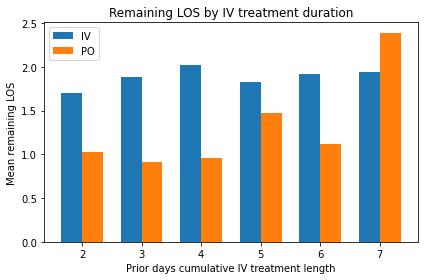

In [6]:
labels = ['2', '3', '4', '5', '6', '7']
iv_means = [1.0302457466918715, 0.9109461966604824, 0.9545454545454546, 1.4731182795698925, 1.1219512195121952, 2.3902439024390243]
po_means = [1.7042304886943838, 1.890625, 2.017191977077364, 1.8233766233766233, 1.9192825112107623, 1.9393939393939394]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, po_means, width, label='IV')#, yerr=po_error, ecolor='black', capsize=10)
rects2 = ax.bar(x + width/2, iv_means, width, label='PO')#, yerr=iv_error, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean remaining LOS')
ax.set_title('Remaining LOS by IV treatment duration')
ax.set_xlabel('Prior days cumulative IV treatment length')

ax.set_xticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Early switch, late switch or agree

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

###
# Need to run native filtered_test_data through iv_treatment_length_fun as some errors 
hold_out_data = iv_treatment_length_fun(hold_out_data)
###

individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

stays = hold_out_data['stay_id'].unique()
import random
random.Random(22).shuffle(stays) # Best split from CV
#random.Random(2).shuffle(stays) # First split from CV for testing 
X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'date', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]


14303


In [4]:
data_dict, random_x_list = los_data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_long(
  (layers): Sequential(
    (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=37, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
lb_los_means, lb_mortality_means, lb_count_df2, lb_count_df3, lb_percentage_agree, lb_percentage_early, lb_percentage_late, ub_los_means, ub_mortality_means, ub_count_df2, ub_count_df3, ub_percentage_agree, ub_percentage_early, ub_percentage_late = early_late_agree_fun(data_dict, model, 'long')

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


903
903


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


897
897


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


837
837


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


929
929


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


885
885


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


824
824


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


844
844


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


909
909


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


843
843


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


843
843


In [7]:
lb_los_means
lb_mortality_means
lb_count_df2
lb_count_df3
lb_percentage_agree
lb_percentage_early
lb_percentage_late
ub_los_means
ub_mortality_means
ub_count_df2
ub_count_df3
ub_percentage_agree
ub_percentage_early
ub_percentage_late

,lb_los_mean
lb_difference,
-5,12.270772
-4,9.528738
-3,8.647740
-2,7.615309
-1,5.286628
0,4.620035
1,5.486809
2,7.235245
3,9.000726


,lb_mortality_means
lb_difference,
-6,0.000000
-5,0.400000
-4,0.000000
-3,0.000000
-2,0.090909
-1,0.000000
0,0.050000
1,0.000000
2,0.000000


,lb_count_sum
0,43.100000
-1,30.000000
-2,12.800000
1,10.000000
-3,7.600000
-5,2.888889
-4,4.500000
2,2.000000
3,1.000000
-7,1.666667


,lb_count_sum
0,431.0
-1,300.0
-2,128.0
1,100.0
-3,76.0
-5,26.0
-4,45.0
2,20.0
3,4.0
-7,10.0


0.3769208286853851

0.514825725025031

0.10825344628958393

,ub_los_mean
ub_difference,
-5,15.384901
-3,9.817672
-2,8.362858
-1,6.365997
0,4.561386
1,5.608547
2,6.256754
3,9.013255
4,11.572140


,ub_mortality_means
ub_difference,
-4,0.333333
-3,0.000000
-2,0.166667
-1,0.000000
0,0.021277
1,0.050000
2,0.000000
3,0.000000
5,0.000000


,ub_count_mean
0,46.80
1,23.80
2,7.40
-2,7.90
-1,17.40
-3,4.50
3,2.75
4,1.50
5,1.20
-5,1.50


,ub_count_sum
0,468.0
1,238.0
2,74.0
-2,79.0
-1,174.0
-3,45.0
3,22.0
4,9.0
5,6.0
-5,12.0


0.40727308417461644

0.28379035408484327

0.3089365617405403

Text(0, 0.5, 'Mean LOS')

Text(0.5, 1.0, 'Patient LOS by switch event temporal difference')

Text(0.5, 0, 'Number of days between the real and predicted switch event')

(0.0, 20.0)

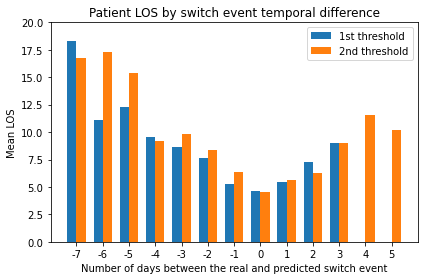

In [19]:
# Decided to go with -7 to 5 as good range for both plots

labels = ['-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5']

lb_los_mean = [18.296902,
11.096035,
12.270772,
9.528738,
8.647740,
7.615309,
5.286628,
4.620035,
5.486809,
7.235245,
9.000726, 0, 0]



ub_los_mean =[16.786562,
17.295278,
15.384901,
9.223407,
9.817672,
8.362858,
6.365997,
4.561386,
5.608547,
6.256754,
9.013255,
11.572140,
10.190426]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lb_los_mean, width, label='1st threshold')#, yerr=po_error, ecolor='black', capsize=10)
rects2 = ax.bar(x + width/2, ub_los_mean, width, label='2nd threshold')#, yerr=iv_error, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean LOS')
ax.set_title('Patient LOS by switch event temporal difference')
ax.set_xlabel('Number of days between the real and predicted switch event')

ax.set_ylim(0,20)


ax.set_xticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()